🚀 啟動 SparkSession...
✔️ SparkSession 建立完成
📥 讀取資料中 ...
✔️ 載入資料完成，共 9504852 筆交易
🔄 產生 PoH 鏈式雜湊欄位 ...


🔗 產生 PoH 雜湊鏈中...: 100%|██████████| 9504852/9504852 [00:13<00:00, 714773.16it/s]


✔️ PoH 雜湊計算完成
🧩 TD-UF 步驟：建立交易圖的頂點與邊 ...
✔️ 頂點數: 9504852，邊數: 0
🔗 TD-UF 步驟：計算分群（connectedComponents） ...


c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


✔️ 完成分群計算
🔗 TD-UF 步驟：Join 原始交易 ...
✔️ Join 完成，資料筆數: 9504852
📊 群組內聚合特徵中 ...
✔️ 群組統計完成
⏱️ TD-UF 分群 + 特徵聚合運算時間：100.93 秒
🚚 一次 collect 到 pandas ...（用完自動刪）
⏱️ toPandas() 運算時間：130.89 秒
✔️ 暫存檔案儲存完成 (tduf_group_features_temp.csv) 共 9504852 筆
🔄 十折分層交叉驗證中 ...
  🚩 Fold 1/10 訓練與測試 ...
  🚩 Fold 2/10 訓練與測試 ...
  🚩 Fold 3/10 訓練與測試 ...
  🚩 Fold 4/10 訓練與測試 ...
  🚩 Fold 5/10 訓練與測試 ...
  🚩 Fold 6/10 訓練與測試 ...
  🚩 Fold 7/10 訓練與測試 ...
  🚩 Fold 8/10 訓練與測試 ...
  🚩 Fold 9/10 訓練與測試 ...
  🚩 Fold 10/10 訓練與測試 ...

📌 TD-UF (GraphFrames) + LR (StratifiedKFold)
╒═══════════╤════════════╕
│ 指標      │     平均值 │
╞═══════════╪════════════╡
│ Accuracy  │ 0.998966   │
├───────────┼────────────┤
│ Precision │ 1          │
├───────────┼────────────┤
│ Recall    │ 0.00465925 │
├───────────┼────────────┤
│ F1 Score  │ 0.00926792 │
╘═══════════╧════════════╛
⏱️ Sklearn LR 十折訓練+推論運算時間：860.55 秒
⏱️ TD-UF 分群 + 特徵聚合 + Sklearn LR 總運算時間：961.49 秒
🧹 已自動刪除暫存 CSV：tduf_group_features_temp.csv
🚩 Baseline 全特徵邏輯迴歸訓練中 ...
⏱️ Baseline LR (PySpa

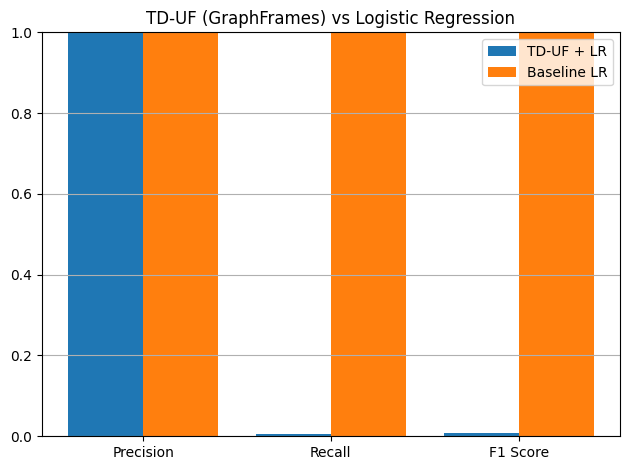

✅ 全部流程執行完畢！


In [1]:
import os
import time
import hashlib
import pandas as pd
import numpy as np
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, concat_ws, monotonically_increasing_id, lag, collect_list
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import min as spark_min, max as spark_max, avg, stddev, count
from graphframes import GraphFrame
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression as SklearnLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression as SparkLR
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from tabulate import tabulate
import matplotlib.pyplot as plt

# 強制設定 Java/Hadoop 路徑
os.environ["JAVA_HOME"] = r"C:\Program Files\Gephi-0.10.1\jre-x64\jdk-11.0.17+8-jre"
os.environ["HADOOP_HOME"] = r"C:\Winutils"
os.environ["PATH"] = os.environ["JAVA_HOME"] + r";" + os.environ["HADOOP_HOME"] + r"\bin;" + os.environ["PATH"]

# ====== Step 0: 建立 SparkSession ======
print("🚀 啟動 SparkSession...")
spark = SparkSession.builder \
    .appName("TD-UF (GraphFrames) vs Logistic Regression") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
    .getOrCreate()
spark.sparkContext.setCheckpointDir("file:///C:/Users/Leon/Desktop/spark-checkpoint")
print("✔️ SparkSession 建立完成")

# ====== Step 1: 日期字串轉 epoch timestamp ======
def to_epoch(dt):
    try:
        return int(time.mktime(time.strptime(dt, "%Y-%m-%d %H:%M:%S")))
    except Exception:
        return 0
udf_epoch = udf(to_epoch, IntegerType())

# ====== Step 2: 讀取資料，加 tx_id、timestamp ======
print("📥 讀取資料中 ...")
raw_path = r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\SAML-D.csv"
df = spark.read.csv(raw_path, header=True, inferSchema=True)
df = df.withColumn("timestamp", udf_epoch(concat_ws(" ", col("Date").cast("string"), col("Time").cast("string"))))
df = df.withColumn("tx_id", monotonically_increasing_id())
print(f"✔️ 載入資料完成，共 {df.count()} 筆交易")

# ====== Step 3: 計算 PoH 鏈式雜湊 ======
def poh_chain(records):
    pohs = []
    prev_poh = ""
    for row in tqdm(records, desc="🔗 產生 PoH 雜湊鏈中..."):
        txid_str = str(row['tx_id'])
        poh = hashlib.sha256((prev_poh + txid_str).encode()).hexdigest()
        pohs.append(poh)
        prev_poh = poh
    return pohs

print("🔄 產生 PoH 鏈式雜湊欄位 ...")
tx_pd = df.orderBy("tx_id").select(
    "tx_id", "Sender_account", "Receiver_account", "timestamp", "Amount", "Is_laundering"
).toPandas()
tx_pd["poh"] = poh_chain(tx_pd.to_dict('records'))
df = spark.createDataFrame(tx_pd)
print("✔️ PoH 雜湊計算完成")

tx = df.select("tx_id", "Sender_account", "Receiver_account", "timestamp", "Amount", "Is_laundering", "poh")

# ====== Step 3.5: TD-UF 分群 + 聚合總運算時間（記錄 runtime） ======
t_tduf_start = time.time()

# ====== TD-UF 分群 ======
print("🧩 TD-UF 步驟：建立交易圖的頂點與邊 ...")
vertices = tx.select(col("tx_id").alias("id")).distinct()
edges_df = (
    tx.alias("a").join(tx.alias("b"),
    (col("a.Receiver_account") == col("b.Sender_account")) &
    (col("a.timestamp") < col("b.timestamp")),
    "inner")
    .select(col("a.tx_id").alias("src"), col("b.tx_id").alias("dst"))
    .distinct()
)
print(f"✔️ 頂點數: {vertices.count()}，邊數: {edges_df.count()}")

print("🔗 TD-UF 步驟：計算分群（connectedComponents） ...")
gf = GraphFrame(vertices, edges_df)
components = gf.connectedComponents()
print(f"✔️ 完成分群計算")

print("🔗 TD-UF 步驟：Join 原始交易 ...")
dfc = components.join(tx, components.id == tx.tx_id)
print(f"✔️ Join 完成，資料筆數: {dfc.count()}")

# ====== Step 4: 聚合特徵 ======
print("📊 群組內聚合特徵中 ...")
w = Window.partitionBy("component").orderBy("timestamp")
dfc = (dfc.withColumn("prev_ts", lag("timestamp", 1).over(w))
           .withColumn("gap", col("timestamp") - col("prev_ts")))

agg_df = (
    dfc.groupBy("component")
    .agg(
        spark_min("timestamp").alias("start_ts"),
        count("timestamp").alias("tx_count"),
        avg("Amount").alias("avg_amt"),
        stddev("Amount").alias("std_amt"),
        spark_max("Amount").alias("max_amt"),
        spark_min("Amount").alias("min_amt"),
        avg("gap").alias("avg_gap"),
        stddev("gap").alias("std_gap"),
        spark_max("gap").alias("max_gap"),
        spark_min("gap").alias("min_gap"),
        spark_max("Is_laundering").alias("label"),
        collect_list("poh").alias("poh_hashes")
    ).fillna({"std_amt": 0, "std_gap": 0})
)
print("✔️ 群組統計完成")
t_tduf_end = time.time()
print(f"⏱️ TD-UF 分群 + 特徵聚合運算時間：{t_tduf_end - t_tduf_start:.2f} 秒")   # <--- 計時

# ====== Step 5: 一次 collect ======
print("🚚 一次 collect 到 pandas ...（用完自動刪）")
t_collect_start = time.time()
agg_pd = agg_df.toPandas()
t_collect_end = time.time()
print(f"⏱️ toPandas() 運算時間：{t_collect_end - t_collect_start:.2f} 秒")

# ==== 儲存暫存檔案 ====
TEMP_CSV = "tduf_group_features_temp.csv"
agg_pd["poh_hashes"] = agg_pd["poh_hashes"].apply(lambda x: ";".join(map(str, x)))
agg_pd.to_csv(TEMP_CSV, index=False, encoding="utf-8-sig")
print(f"✔️ 暫存檔案儲存完成 ({TEMP_CSV}) 共 {len(agg_pd)} 筆")

# ====== Step 6: 讀取暫存檔案，做十折交叉驗證與邏輯迴歸計時 ======
print("🔄 十折分層交叉驗證中 ...")
t_lr_start = time.time()
agg_pd = pd.read_csv(TEMP_CSV)
agg_pd = agg_pd.fillna(0)
feature_cols = [
    "tx_count", "avg_amt", "std_amt", "max_amt", "min_amt",
    "avg_gap", "std_gap", "max_gap", "min_gap"
]
X = agg_pd[feature_cols].values
y = agg_pd["label"].values

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accs, precs, recs, f1s = [], [], [], []
agg_pd["cv_fold"] = -1
cv_pred = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"  🚩 Fold {fold}/10 訓練與測試 ...")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf = SklearnLR(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred, zero_division=0))
    recs.append(recall_score(y_test, y_pred, zero_division=0))
    f1s.append(f1_score(y_test, y_pred, zero_division=0))
    agg_pd.loc[test_idx, "cv_fold"] = fold
    for idx, p in zip(test_idx, y_pred):
        cv_pred.append((agg_pd.iloc[idx]["component"], int(agg_pd.iloc[idx]["label"]), int(p), fold))
t_lr_end = time.time()

print("\n📌 TD-UF (GraphFrames) + LR (StratifiedKFold)")
print(tabulate([
    ("Accuracy", np.mean(accs)), 
    ("Precision", np.mean(precs)),
    ("Recall", np.mean(recs)),
    ("F1 Score", np.mean(f1s))
], headers=["指標", "平均值"], tablefmt="fancy_grid"))

print(f"⏱️ Sklearn LR 十折訓練+推論運算時間：{t_lr_end - t_lr_start:.2f} 秒")
print(f"⏱️ TD-UF 分群 + 特徵聚合 + Sklearn LR 總運算時間：{(t_tduf_end - t_tduf_start) + (t_lr_end - t_lr_start):.2f} 秒")

# ====== 清除暫存檔案 ======
try:
    os.remove(TEMP_CSV)
    print(f"🧹 已自動刪除暫存 CSV：{TEMP_CSV}")
except Exception as e:
    print(f"⚠️ 刪除暫存 CSV 失敗：{e}")

# ====== Step 7: Baseline（全欄位 LR, 用 PySpark） ======
print("🚩 Baseline 全特徵邏輯迴歸訓練中 ...")

# -- 重新讀原始 CSV，避免欄位不見
df_full = spark.read.csv(raw_path, header=True, inferSchema=True)
df_full = df_full.withColumn("timestamp", udf_epoch(concat_ws(" ", col("Date").cast("string"), col("Time").cast("string"))))
df_full = df_full.withColumn("label", col("Is_laundering"))

categorical_cols = ["Payment_currency", "Received_currency", "Sender_bank_location", "Receiver_bank_location", "Payment_type"]
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx").fit(df_full) for c in categorical_cols]
for indexer in indexers:
    df_full = indexer.transform(df_full)

feature_cols_full = ["Amount", "timestamp"] + [f"{c}_idx" for c in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols_full, outputCol="features")
vector_df = assembler.transform(df_full).select("features", "label")
train_b, val_b, test_b = vector_df.randomSplit([0.7, 0.2, 0.1], seed=42)

lr = SparkLR(maxIter=100, regParam=0.01)
t2 = time.time()
model_base = lr.fit(train_b)
result_base = model_base.transform(test_b)
t3 = time.time()
print(f"⏱️ Baseline LR (PySpark) 訓練與推論運算時間: {t3 - t2:.2f} 秒")

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
acc_base = evaluator.setMetricName("accuracy").evaluate(result_base)
f1_base  = evaluator.setMetricName("f1").evaluate(result_base)
prec_base = evaluator.setMetricName("weightedPrecision").evaluate(result_base)
rec_base = evaluator.setMetricName("weightedRecall").evaluate(result_base)

print("\n📌 Baseline LR (PySpark)")
print(tabulate([
    ("Accuracy", acc_base), 
    ("Precision", prec_base), 
    ("Recall", rec_base), 
    ("F1 Score", f1_base), 
    ("Time", t3 - t2)
], headers=["指標", "數值"], tablefmt="fancy_grid"))

# ====== Step 8: 精準度比較圖表 ======
print("📊 畫出 TD-UF 與 Baseline 精準度比較圖 ...")
labels = ["Precision", "Recall", "F1 Score"]
x = np.arange(len(labels))
plt.bar(x - 0.2, [np.mean(precs), np.mean(recs), np.mean(f1s)], width=0.4, label="TD-UF + LR")
plt.bar(x + 0.2, [prec_base, rec_base, f1_base], width=0.4, label="Baseline LR")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("TD-UF (GraphFrames) vs Logistic Regression")
plt.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

spark.stop()
print("✅ 全部流程執行完畢！")
